# Проект: “Аналитика данных медицинского центра”
----

## Содержание <a class="anchor" id="sod"></a> 

### [Шаг 1. Введение и загрузка данных](#sh1)
### [Шаг 2. Предварительный анализ данных (EDA)](#sh2)
### [Шаг 3. Исследовательский анализ данных](#sh3)
### [Шаг 4. Выводы](#sh4)

### Шаг 1. Введение и загрузка данных

В рамках проекта поработаем с реальными сырыми данными от одного медицинского центра.

#### Цель проекта: Произвести анализ изменения цены лечения в медицинской клинике в 2022 году относительно 2021 года с целью определить ключевые драйверы изменения цены лечения.

#### Описание данных:
- record_id - уникальный идентификатор строки данных;
- service_date - дата оказания медицинской услуги;
- service_name - наименование медицинской услуги;
- service_number - количество услуг;
- service_amount - сумма выплат (стоимость оказанных услуг в рублях);
- insured - уникальный идентификатор пациента;
- sex_id - пол пациента;
- age_for_service_date - возраст пациента.


In [1]:
# загрузка необходимых библиотек
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import datetime
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns

from scipy import stats as st
import math as mth


import pathlib
from pathlib import Path

# Вывод всех операций в ячейках
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Прячем придупреждения 
import warnings
warnings.filterwarnings('ignore')
# Изменяем формат демонстрации чисел для лучшего восприятия
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# загрузка данных
df = pd.read_excel('data_test_task_2022.xlsx')
df.head()

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
0,30268157003,2021-01-24,Прием первичный,1470,1,490777,2.00,26
1,30268157103,2021-01-24,"Взятие материала на посев, цитологическое иссл...",284,1,490777,2.00,26
2,30268157203,2021-01-24,"Посев отдел, дыхательных путей - слизистая зев...",1134,1,490777,2.00,26
3,30268157303,2021-01-24,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,490777,2.00,26
4,30268157403,2021-01-24,Ревматоидный фактор,420,1,490777,2.00,26


#### Данные загружены

### Шаг 2. Предварительный анализ данных (EDA) <a class="anchor" id="sh2"></a> 

#### 2.1. Подготовка данныx, оценка их целостности

In [3]:
# словать имен колонок
name_col = {'record_id':'Уникальный идентификатор строки данных',
            'service_date':'Дата оказания медицинской услуги',
            'service_name':'Наименование медицинской услуги',
            'service_number':'Количество услуг',
            'service_amount':'Стоимость оказанных услуг',
            'insured':'Уникальный идентификатор пациента',
            'sex_id':'Пол пациента',
            'age_for_service_date':'Возраст пациента'}

print('Представлен дата сет с колонками:')
for col in df.columns:
    print(col,'-',name_col[col])
print('-'*100)
print('Размер датасета',df.shape,', полных дубликатов -',df.duplicated().sum())
print('Количество пропусков по столбцам: ')
print(df.isna().sum())
print('-'*100)
print('Информация о столбцах')
df.info()
print('Основные статистические показатели всего набора данных')
print(df.describe())
print('-'*100)

Представлен дата сет с колонками:
record_id - Уникальный идентификатор строки данных
service_date - Дата оказания медицинской услуги
service_name - Наименование медицинской услуги
service_amount - Стоимость оказанных услуг
service_number - Количество услуг
insured - Уникальный идентификатор пациента
sex_id - Пол пациента
age_for_service_date - Возраст пациента
----------------------------------------------------------------------------------------------------
Размер датасета (85369, 8) , полных дубликатов - 0
Количество пропусков по столбцам: 
record_id                0
service_date             0
service_name             0
service_amount           0
service_number           0
insured                  0
sex_id                  21
age_for_service_date     0
dtype: int64
----------------------------------------------------------------------------------------------------
Информация о столбцах
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85369 entries, 0 to 85368
Data columns (total 8 

#### Имеем массив данных размером (85369, 8):
#### - Нет полных дубликатов
#### - Пропуски в колонке пол пациента в 21 строке, возможно вызваны незаполнением поля анкеты. Если заполнить пропуски не сможем - удаляем строки с пропусками, менее 1% выборки
#### - Некорректный тип даты - исправляем 
#### - 75% значений service_number равняется 1 и среднне 1.02 - проверим на выбросы
#### - 75% клиентов клиники не старше 41 года, распределение вероятно близкое к нормальному со смещением влево

#### 2.2. Исправляем типы данных и пропуски

In [4]:
df['record_id'].duplicated().sum()

0

In [5]:
# Пропуски
print('Количество пропусков в указании пола', df['sex_id'].isna().sum())
print('Какие id пользователей с проусками пола?')
df[df['sex_id'].isna()==True]['insured'].value_counts()
print('Попробуем заполнить пропуски из других строк, или удалим, размер дата сета до удаления',df.shape)
sh = df.shape[0]
for el in df[df['sex_id'].isna()==True]['insured'].value_counts().index:
    try:
        df.loc[df['insured']==el,'sex_id'] = df.loc[df['insured'] == el,'sex_id'].value_counts().index[0]
    except:
        pass
# удаляем строки с пропусками
df = df[df['sex_id'].isna()==False]
print('Размер дата сета после удаления пропусков',df.shape, 'удалили',df.shape[0]-sh,'строк')


Количество пропусков в указании пола 21
Какие id пользователей с проусками пола?


512590    17
221581     4
Name: insured, dtype: int64

Попробуем заполнить пропуски из других строк, или удалим, размер дата сета до удаления (85369, 8)
Размер дата сета после удаления пропусков (85365, 8) удалили -4 строк


In [6]:
# исправляем тип даты
df['service_date'] = pd.to_datetime(df['service_date'])

#### 2.3. Уникальные значения и диапазоны

Для числовых значений удостоверимся в адекватном диапазоне, а так же ознакомимся с категориальными значениями

In [7]:
for col in ['service_date','service_number','sex_id','age_for_service_date','service_amount']:
    print('Минимальное и максимальное значение колонки',name_col[col])
    print('min =',df[col].min())
    print('max =',df[col].max())

Минимальное и максимальное значение колонки Дата оказания медицинской услуги
min = 2021-01-03 00:00:00
max = 2022-08-31 00:00:00
Минимальное и максимальное значение колонки Количество услуг
min = 1
max = 16
Минимальное и максимальное значение колонки Пол пациента
min = 1.0
max = 2.0
Минимальное и максимальное значение колонки Возраст пациента
min = 0
max = 83
Минимальное и максимальное значение колонки Стоимость оказанных услуг
min = 147
max = 26999


#### Вренной интервал не равномерный, данные за 2021 год обрываются в августе, следует учесть это сравнивая суммы  выручки по годам
#### Количество услуг имеет положительные значения, но верхняя граница 16  похожа на выброс
#### Колонка, определяющая пол клиента, как и ожидалось имеет дискретные значения
#### Границы возраста клиентов имеют положительные значения в разумных пределах
#### Суммы за услуги положительные числа - адекватно
#### По названию услуги можно разбить на некоторые категории

#### 2.4. Выбросы

Построим 'ящики с усами' и оценим выбросы по уровню персентилей

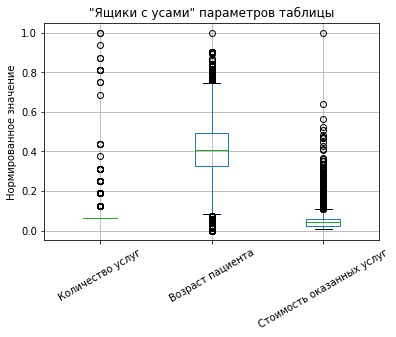

In [8]:
# Строим 'ящики с усами', предварительно пронормировав данные
(df[['service_number',
     'age_for_service_date',
     'service_amount']]/df[['service_number',
                            'age_for_service_date',
                            'service_amount']].max()).rename(columns={'service_number':name_col['service_number'],
                                                        'age_for_service_date':name_col['age_for_service_date'],
                                                        'service_amount':name_col['service_amount']}).boxplot()
plt.title('"Ящики с усами" параметров таблицы')
plt.ylabel('Нормированное значение')
plt.xticks(rotation=30)
plt.show();

Text(0, 0.5, 'Количество значений в выборке')

Text(0.5, 0, 'Количество услуг')

Text(0.5, 1.0, 'Распределение параметра: Количество услуг')

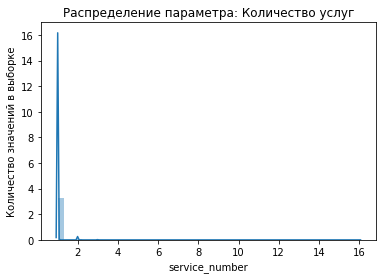

Text(0, 0.5, 'Количество значений в выборке')

Text(0.5, 0, 'Возраст пациента')

Text(0.5, 1.0, 'Распределение параметра: Возраст пациента')

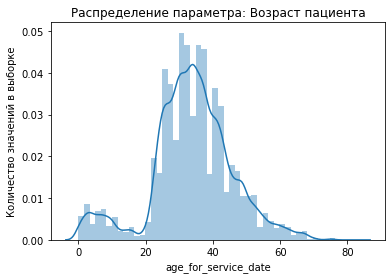

Text(0, 0.5, 'Количество значений в выборке')

Text(0.5, 0, 'Стоимость оказанных услуг')

Text(0.5, 1.0, 'Распределение параметра: Стоимость оказанных услуг')

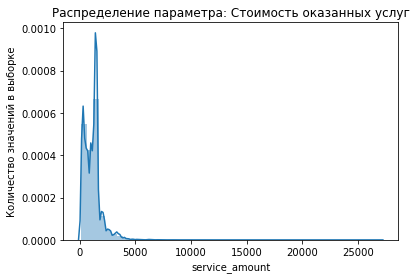

In [9]:
for el in ['service_number','age_for_service_date','service_amount']:
    plt.ylabel('Количество значений в выборке')
    plt.xlabel(name_col[el])
    plt.title('Распределение параметра: {}'.format(name_col[el]))
    plot = sns.distplot(df[el])
    plt.show();
  

In [10]:
for k,v in {'service_number':[90,95,99],
            'age_for_service_date':[25,50,75],
            'service_amount':[90,95,99]}.items():
    name_col[k]
    for per in v:
        print('Персентиль',per,'%:',np.percentile(df[k],per))

'Количество услуг'

Персентиль 90 %: 1.0
Персентиль 95 %: 1.0
Персентиль 99 %: 2.0


'Возраст пациента'

Персентиль 25 %: 27.0
Персентиль 50 %: 34.0
Персентиль 75 %: 41.0


'Стоимость оказанных услуг'

Персентиль 90 %: 1980.0
Персентиль 95 %: 2540.0
Персентиль 99 %: 3780.0


#### Итак, всего:
- 1% значений количества услуг больше 2
- 75% пациентов не старше 41 года - тут мы не будем искать выбросы
- 99% пациэнтов заплатили не более 3780 рублей за услугу, более этой сумы можем посчитать выбросами

#### Посчитаем сколько данных потеряем, если уберем выбросы с пороговым значением  - персентиль 99%


In [11]:
# срез данных - выбросы
emissions = df.loc[(df['service_number']>2)&(df['service_amount']>3780.0)]
print('Выбросы')
emissions
print("{:.2f}% теряем, убирая {} выбросов".format(100*emissions.shape[0]/df.shape[0],emissions.shape[0]))
#print('Выбросы распределены по годам 2021/2022 в строках {}/{} по сумме выкупа {}/{}')
# убираем выбросы
df = df.loc[(df['service_number']<=2)&(df['service_amount']<=3780.0)]

Выбросы


,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
8528,30620847703,2021-04-12,Электронейромиография - игольчатая миография в...,7560,3,544846,2.00,55
10245,30621019503,2021-04-11,Гистологическое исследование биоптата органов ...,8664,3,243435,2.00,36
11398,30621135503,2021-04-13,"Пункция молочной железы, опухолей кожи, лимфоу...",6930,5,243315,2.00,40
11399,30621135603,2021-04-13,Исследование пунктатов молочной железы и кожи,4045,5,243315,2.00,40
11425,30621138203,2021-04-13,УЗИ - контроль при пункции,4410,5,243315,2.00,40
13256,30786126603,2021-05-22,"Пункция молочной железы, опухолей кожи, лимфоу...",4158,3,150261,2.00,43
14251,30786226103,2021-05-16,Наложение противоотечного противовоспалительно...,4095,3,531654,1.00,59
16695,30961603903,2021-06-28,Электронейромиография - игольчатая миография в...,7560,3,544854,2.00,45
19327,30961867903,2021-06-26,"Пункция молочной железы, опухолей кожи, лимфоу...",4158,3,596580,2.00,33
24353,31249390403,2021-08-20,Гистологическое исследование операционного мат...,9704,4,538768,2.00,39


0.03% теряем, убирая 26 выбросов


#### 2.5. Дополнительные колонки

Добавим дополнительные колонки для анализа данных:
- Год **year**
- Месяц **month**
- Месяц и год **mon_year**
- Категория услуг **category**
- Стоимость услуги **service_price**

#### По Топ - 20 слов распределим наименования услуг по категориям

In [12]:
# дополним словарь
name_col['year'] = 'Год оказания услуги'
name_col['month'] = 'Месяц оказания услуги'
name_col['category'] = 'Категория услуг'
name_col['service_price'] = 'Стоимость услуги'
name_col['mon_year'] = 'Месяц'

# столбец с годами
df['year'] = df['service_date'].dt.year
# столбец с месяцами
df['month'] = df['service_date'].dt.month
# столбец с годами и месяцами
df['mon_year'] = df['service_date'].dt.to_period('M')
# столбец с категориями
df['category'] = df['service_name'].str.lower()
# столбец со стоимостью услуги
df['service_price'] = df['service_amount']/df['service_number']

# ищем ключевые слова
words = pd.Series(df['service_name'].str.lower().to_string().split()).value_counts().reset_index()
# топ-20 ключевых слов названий 
words.head(20).T
# словарь категорий - названий
dict_cat = {'прием':['прием','осмотр','Консультация','Подбор','Типирование'],
            
            'анализы':['анализ','крови','кровь','взятие','посев','ревматоидный фактор','белок','мазок','креатинин',
                       'мочевая кислота','мочевина','Триглицериды','Холестерин','аланинаминотрансфераза',
                       'Альдостерон','ЛПНП','Кортизол','Ренин','Ангиотензин','Т4','ТТГ','Гепатит','АСТ',
                       'Билирубин','общий','IgM','IgМ','IgG','IgA','IgE','Антитела','Железо','Ферритин','Протромбин','ВИЧ','РНК','Инсулин',
                       'АТ к ТПО (тиреопероксидазе)','Калий','Натрий','Магний','Соскоб на грибы','Т3 св','ФСГ',
                       'ЛГ','Пролактин','альфа-амилаза','ГГТ','Фосфотаза щелочная','ВИТАМИН','гемоглобин','феррин',
                       'Helicobacter pylori','Фолиевая кислота','ЛПВП','Кальций','Лейкоцитарная формула','СОЭ',
                       'Rh-фактор','Экспресс - метод','Углеводы','Фибриноген','Альбумин','Тромбиновое время',
                       'Соскоб','гидроксипрогестерон','Фосфор','гормон','проба','антиген','Кальцитонин',
                       'тиреоглобулину)','АСЛО','ромбин','Слюна','Биопсия','Эпителий','Эстрадиол','протеин',
                       'Плесень','Клещ','пыли','Липаза','Хлор','Кал','Тиреоглобулин','Пыльца','Ретикулоциты',
                       'Келл','АТ к гладкой мускулатуре','ЛДГ','ХГЧ','Д-димер','Белков','Креатинкиназа',
                       'Прогестерон','Обнаружение','скопия','тромбоцит','Таракан','Перо попугая','Цинк','С-пептид',
                       'ДЭА-С','Серотонин','Гомоцистеин','Т3','Лактат','молочная кислота','ДНК','Флороценоз',
                       'Латекс','АТ к','Андростендион','Катехоламины','адреналин', 'норадреналин', 'дофамин',
                       'Сифилис RPR (кардиолипиновый а/ген)','СА-72-4','Холинэстераза'],
            
            'исследования':['исследование','рентгенография','экг','ЭЭГ','УЗИ','терапия','сканирование','теста',
                            'Расшифровка','Измерение','Рефрактометрия','Тест','кольпоскопия','Скиаскопия',
                            'Катетеризация','Пульсоксиметрия','Эндоскопия','визуализация','скопическая','метрия','Риноцитограмма',
                            'скрининг'],
            
            'физиотерапия':['массаж','магнитотерапия','токи','Фонофорез','Сеанс','ЛФК','Электромиостимуляц',
                            'маневр','процедур','Пребывание'],
            
            'манипуляции':['манипуляц','обработка','смазывание','Установка','снятие','Инстиляция','Анемизация',
                           'Промывание носа методом перемещения','Удаление','инъекци','Перевязка','анестезия',
                           'Наложение','Функция','графия','Инстилляция','Туалет','Постановка','Аноскопия',
                           'препаратов','применение','пробы','Вакцинация','блокада','Санация','Прижигание',
                           'Продувание','Промывание','пункци','Аппликация','Вскрыт','Иммобилизац','Введение',
                           'Вливание','Криодеструкция','тампонада','Коагуляц','аспирация','Туширован',
                           'при переломе','Репозиция','Коррекция','Зондирован']}

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
index,прием,первичный,повторный,крови,(1,исследование,сеанс),общий,взятие,анализ,ультразвуковое,из,вены,периферической,с,"форм,,",соэ),(лейкоцитарная,магнитотерапия,рентгенография
0,26118,15037,10944,8288,8071,7467,7258,6192,6174,5131,4379,4254,4211,4211,3572,3190,3190,3190,2838,2453


In [13]:
df.head()

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,year,month,mon_year,category,service_price
0,30268157003,2021-01-24,Прием первичный,1470,1,490777,2.00,26,2021,1,2021-01,прием первичный,"1,470.00"
1,30268157103,2021-01-24,"Взятие материала на посев, цитологическое иссл...",284,1,490777,2.00,26,2021,1,2021-01,"взятие материала на посев, цитологическое иссл...",284.00
2,30268157203,2021-01-24,"Посев отдел, дыхательных путей - слизистая зев...",1134,1,490777,2.00,26,2021,1,2021-01,"посев отдел, дыхательных путей - слизистая зев...","1,134.00"
3,30268157303,2021-01-24,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,490777,2.00,26,2021,1,2021-01,"общий анализ крови (лейкоцитарная форм,, соэ)",693.00
4,30268157403,2021-01-24,Ревматоидный фактор,420,1,490777,2.00,26,2021,1,2021-01,ревматоидный фактор,420.00


In [14]:
# функция распределения наименований услуг по категориям
def cat(s):
    # заполним категории из словаря
    for k,v in dict_cat.items():
        for searchfor in v:
            if s.find(searchfor.lower()) != -1:
                return k

In [15]:
# распределяем по категориям 
try:
    df['category'] = df['service_name'].str.lower().apply(cat)
except:
    pass
print('Количество строк каждой категории')
# сколько позиций каждой категории
df['category'].value_counts()
# проверим, что распределили все позиции по категориям
df['category'].isna().sum()
df[df['category'].isna() == True]
df[df['category'].isna() == True]['service_name'].head()

Количество строк каждой категории


анализы         28669
прием           26842
исследования    19208
физиотерапия     6216
манипуляции      3450
Name: category, dtype: int64

0

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,year,month,mon_year,category,service_price


Series([], Name: service_name, dtype: object)

Разобьем данные на две выборки по году

In [16]:
# теперь данные будут представлены таблицами по годам
df21 = df.loc[df['year']==2021]
df22 = df.loc[df['year']==2022]
print('Соотношение строк в датасетах по годам')
pd.concat([df21['year'].value_counts(),df22['year'].value_counts()])

Соотношение строк в датасетах по годам


2021    43895
2022    40490
Name: year, dtype: int64

#### Не взирая на то, что данные за 2022 год предствалены за 3/4 периода, в отличии от полных данных 2021 года - выборки получились близкими по размеру. Вероятно, в 2022 году преобретают больше услуг или произошло дробление услуг на большее количество строк. Наши предположения проверим в следующем блоке

#### [-> Содержание](#sod)

### Шаг 3. Исследовательский анализ данных <a class="anchor" id="sh3"></a> 


<div class="alert alert-secondary"; style="border-left: 7px solid red">
<b> <u>План: </u>  
    
    1) Как менялась цена по месяцам и на какие категории товаров?
    
    2) Как пациенты среагировали на изменение цен?
    
    3) Портрет пациента
    
    4) Сравнение прибыли за аналогичные периоды 2021 года и 2022 года
    
    
<u>Гипотезы:</u>
    
    1) Скачки прибыли вызваны пациентами определенных половозрастных групп
    
    2) Средняя стоимость обслуживания пациентов изменилась из-за изменения структуры оказываемых услуг (раньше были дорогие услуги, теперь дешевые или наоборот) 
</b>   
</div>



#### 3.1. Исследование изменений цены услуг


**Сколько раз менялась цена?**

In [17]:
# Сколько уникальных услуг в клинике?
print('В клинике {} уникальных услуг'.format(df['service_name'].nunique()))
# Сколько раз менялась ценв
print('Количество уникальных цен на каждую услугу')
service_name = df.pivot_table(index = ['service_name'],
                              values = 'service_price',
                              aggfunc = 'nunique')
service_name.value_counts()

В клинике 772 уникальных услуг
Количество уникальных цен на каждую услугу


service_price
2                283
3                246
1                233
4                  8
5                  2
dtype: int64

#### На 10 услуг стоимость менялась 4-5 раз за период исследованя, на 233 услуги стоимость не менялась вообще, для остальных менялась 2-3 раза


#### Необходимо сравнить стоимость услуг, присутствующих одновременно в 2021 и в 2022, сколько это от выборки? Посмотрим по ним динамику роста цен

In [18]:
# Стоимость услуг по месяцам и в скольких годах они были
service_name = df.pivot_table(index = ['category','service_name'],
                                   columns = ['mon_year'],
                                   values = 'service_price',
                                   aggfunc = 'max'
       ).join(
       df.pivot_table(index = ['category','service_name'],
                      values = ['year'],
                      aggfunc = 'nunique'))

# распределение услуг по годам
print('Распределение услуг по годам. 1-только в одном из лет,2- в обоих годах')
service_name['year'].value_counts()

# для графика оставляем только услуги, присутствовавшие в обоих периодах(годах)
service_name_clean = service_name.loc[service_name['year']==2].drop('year',axis = 1)

# Заполним пропуски: сначала ближайшим левым значением
service_name_clean = service_name_clean.fillna(method='ffill',axis =1)
# Заполним пропуски: ячейки NaN до первого значения - заполним им
service_name_clean = service_name_clean.fillna(method='bfill',axis =1)
service_name_clean.head()

Распределение услуг по годам. 1-только в одном из лет,2- в обоих годах


2    512
1    260
Name: year, dtype: int64

2021-01  2021-02  \
category service_name                                                           
анализы  (Б1 (11))Аллергопанель IgE шерсть кошки, шерсть... 1,449.00 1,449.00   
         17-OH - гидроксипрогестерон                          610.00   610.00   
         25-OH витамин D (25-гидроксихолекальциферол)       3,255.00 3,255.00   
         Bordetella (pertusis) IgA                            970.00   970.00   
         Bordetella (pertusis) IgG                            630.00   630.00   

                                                             2021-03  2021-04  \
category service_name                                                           
анализы  (Б1 (11))Аллергопанель IgE шерсть кошки, шерсть... 1,449.00 1,449.00   
         17-OH - гидроксипрогестерон                          610.00   610.00   
         25-OH витамин D (25-гидроксихолекальциферол)       3,255.00 3,255.00   
         Bordetella (pertusis) IgA                            970.00   970.00   
         Bordetella (pertusis) IgG                            630.00   630.00   

                                                             2021-05  2021-06  \
category service_name                                                           
анализы  (Б1 (11))Аллергопанель IgE шерсть кошки, шерсть... 1,449.00 1,449.00   
         17-OH - гидроксипрогестерон                          610.00   610.00   
         25-OH витамин D (25-гидроксихолекальциферол)       3,255.00 3,255.00   
         Bordetella (pertusis) IgA                            970.00   970.00   
         Bordetella (pertusis) IgG                            630.00   630.00   

                                                             2021-07  2021-08  \
category service_name                                                           
анализы  (Б1 (11))Аллергопанель IgE шерсть кошки, шерсть... 1,449.00 1,449.00   
         17-OH - гидроксипрогестерон                          610.00   610.00   
         25-OH витамин D (25-гидроксихолекальциферол)       3,255.00 3,255.00   
         Bordetella (pertusis) IgA                            970.00   970.00   
         Bordetella (pertusis) IgG                            630.00   630.00   

                                                             2021-09  2021-10  \
category service_name                                                           
анализы  (Б1 (11))Аллергопанель IgE шерсть кошки, шерсть... 1,449.00 1,520.00   
         17-OH - гидроксипрогестерон                          610.00   610.00   
         25-OH витамин D (25-гидроксихолекальциферол)       3,255.00 3,420.00   
         Bordetella (pertusis) IgA                            970.00   970.00   
         Bordetella (pertusis) IgG                            630.00   630.00   

                                                             2021-11  2021-12  \
category service_name                                                           
анализы  (Б1 (11))Аллергопанель IgE шерсть кошки, шерсть... 1,520.00 1,520.00   
         17-OH - гидроксипрогестерон                          610.00   610.00   
         25-OH витамин D (25-гидроксихолекальциферол)       3,420.00 3,420.00   
         Bordetella (pertusis) IgA                            970.00   970.00   
         Bordetella (pertusis) IgG                            630.00   630.00   

                                                             2022-01  2022-02  \
category service_name                                                           
анализы  (Б1 (11))Аллергопанель IgE шерсть кошки, шерсть... 1,520.00 1,520.00   
         17-OH - гидроксипрогестерон                          610.00   610.00   
         25-OH витамин D (25-гидроксихолекальциферол)       3,420.00 3,420.00   
         Bordetella (pertusis) IgA                            970.00   970.00   
         Bordetella (pertusis) IgG                            630.00   630.00   

                                                             2022-03  2022-04  \
cate

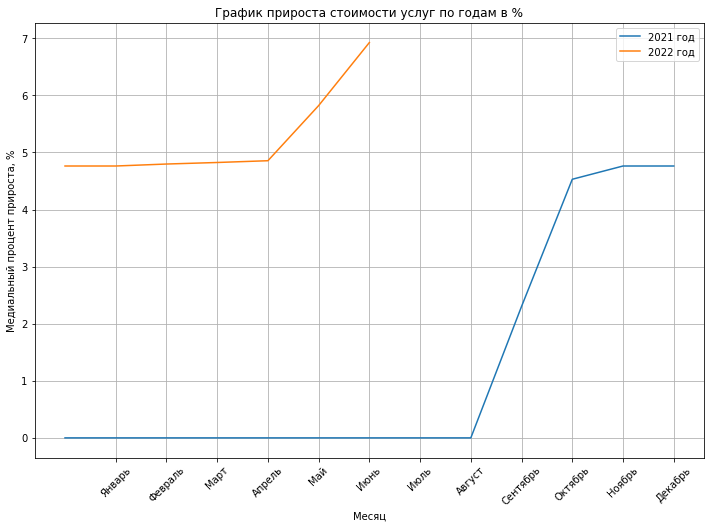

In [19]:
# проведем нормирование - разделим стоимости услуг на стоимость на начало периода,
# вычтем 1 и умножим на 100 - получим прирост стоимости в %
service_name_clean_norm = (100*(service_name_clean.div(service_name_clean[service_name_clean.columns[0]],
                                         axis=0)-1))
price_diff = service_name_clean_norm.median()

# строим график по медиальным значениям прироста
# задаем размер графика
plt.figure(figsize=(12, 8))
ax = price_diff[price_diff.index[:13]].plot()
bx = price_diff[price_diff.index[13:]].plot()
plt.legend(['2021 год','2022 год'])
plt.grid(True)
plt.title('График прироста стоимости услуг по годам в %')
plt.xlabel('Месяц')
plt.ylabel('Медиальный процент прироста, %')
plt.xticks(rotation=45)
plt.xticks(ticks= [i for i in range(1, 13)],
           labels = ['Январь','Февраль','Март','Апрель','Май','Июнь',
                     'Июль','Август','Сентябрь','Октябрь','Ноябрь','Декабрь'])
plt.show();

#### Наблюдаем медиальный рост стоимости услуг в 2 основных этапа - октябрь-ноябрь 2021 года и июль-август 2022 года

#### Интересно, стоимость только росла?


In [20]:
print('В {} случаях стоимость снижалась'.format((service_name_clean.diff(axis=1)<0).sum().sum()))
down_price = (service_name_clean.diff(axis=1)<0).sum()
print('-'*100)
print('Таблица падения цен: месяц - количество услуг со снижением стоимости')
down_price = down_price[down_price>0].reset_index()
down_price.columns = ['месяц','кол-во_услуг']
down_price

В 11 случаях стоимость снижалась
----------------------------------------------------------------------------------------------------
Таблица падения цен: месяц - количество услуг со снижением стоимости


,месяц,кол-во_услуг
0,2021-08,1
1,2021-11,1
2,2022-02,1
3,2022-03,2
4,2022-06,2
5,2022-07,2
6,2022-08,2


#### На 11 услуг стоимость снижалась - вероятно были маркетинговые акции

#### 3) Сопоставить динамику цен с динамикой доходов

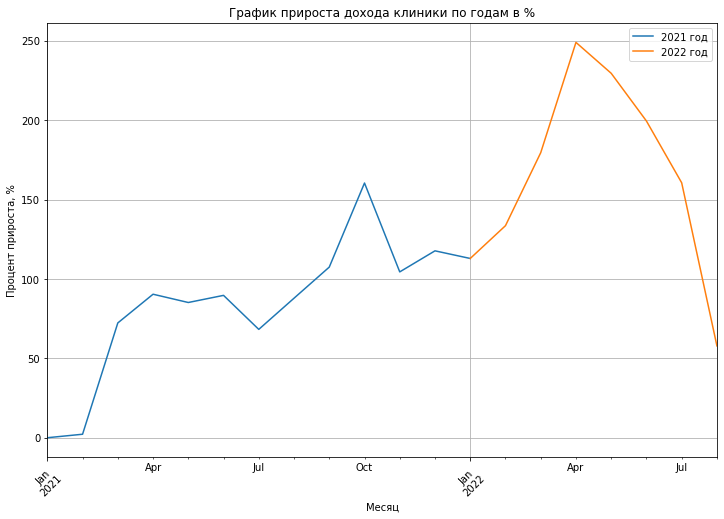

In [21]:
# Сгруппируем доход по месяцам, пронурмируем на значение первого месяца и выведем прирост в процентах дохода
service_amount = df.groupby(by='mon_year')['service_amount'].sum()
service_amount_norm = 100*service_amount/service_amount['2021-01']-100


data = pd.concat([price_diff,service_amount], axis=1)
data = pd.concat([data,service_amount_norm], axis=1)
data.columns = ['Прирост_цены%','Доход','Прирост_дохода%']


# строим график по медиальным значениям прироста
plt.figure(figsize=(12, 8))
service_amount_norm[service_amount_norm.index[:13]].plot()
service_amount_norm[service_amount_norm.index[12:]].plot()
plt.legend(['2021 год','2022 год'])
plt.grid(True)
plt.title('График прироста дохода клиники по годам в %')
plt.xlabel('Месяц')
plt.ylabel('Процент прироста, %')
plt.xticks(rotation=45)

plt.show();

In [22]:
print('Прирост в процентах дохода')
print(data)
print('-'*60)
print('Таблица корреляции прироста стоимости и пророста дохода')
print(data.corr())

Прирост в процентах дохода
         Прирост_цены%    Доход  Прирост_дохода%
2021-01           0.00  2208448             0.00
2021-02           0.00  2257020             2.20
2021-03           0.00  3804828            72.29
2021-04           0.00  4204131            90.37
2021-05           0.00  4089090            85.16
2021-06           0.00  4188210            89.64
2021-07           0.00  3715248            68.23
2021-08           0.00  4148781            87.86
2021-09           0.00  4581379           107.45
2021-10           2.30  5750650           160.39
2021-11           4.53  4514740           104.43
2021-12           4.76  4807540           117.69
2022-01           4.76  4701430           112.88
2022-02           4.76  5157405           133.53
2022-03           4.76  6172050           179.47
2022-04           4.80  7706500           248.96
2022-05           4.82  7276560           229.49
2022-06           4.85  6612720           199.43
2022-07           5.82  5753841           

#### Клиника за период исследования увеличила свои доходы более чем в 2 раза, но с мая 2022 года доход начал падать. Активность пациентов в летний период падает и в 2021 году. Достатоно высокий коэфициэнт корреляции между приростом стоимости и приростом прибыли 0.59 не оправдывается на графиках: прирост стоимости услуг в октябре-ноябре 2021 и  в июне 2022 года вызвал снижение дохода. Теперь нужно понять снижение продаж произошло за счет снижения количества покупок услуг, новых пользователей, среднего чека постоянных пациентов.

#### Оценим средний чек 

In [23]:
# подсчет среднего чека
cheque = df.pivot_table(index = ['year','month'],
               values = ['insured','service_amount'],
               aggfunc = {'insured':'nunique',
                          'service_amount':'sum'})
cheque['cheque'] = cheque['service_amount']/cheque['insured']
cheque[:12].T
print('Средний чек за первые 8 месяцев 2021 года:',round(cheque[:8]['cheque'].mean()))
cheque[12:].T
print('Средний чек за первые 8 месяцев 2022 года:',round(cheque[12:]['cheque'].mean()))
print('Средний чек в 2022 году вырос на {:.2f}% по сравнению с 2021 годом'.format(100*cheque[12:]['cheque'].mean()/cheque[:8]['cheque'].mean()-100))

year                   2021                                         \
month                    1            2            3            4    
insured              285.00       308.00       443.00       465.00   
service_amount 2,208,448.00 2,257,020.00 3,804,828.00 4,204,131.00   
cheque             7,748.94     7,327.99     8,588.78     9,041.14   

year                                                                \
month                    5            6            7            8    
insured              466.00       433.00       447.00       487.00   
service_amount 4,089,090.00 4,188,210.00 3,715,248.00 4,148,781.00   
cheque             8,774.87     9,672.54     8,311.52     8,519.06   

year                                                                
month                    9            10           11           12  
insured              558.00       586.00       536.00       558.00  
service_amount 4,581,379.00 5,750,650.00 4,514,740.00 4,807,540.00  
cheque             8,210.36     9,813.40     8,423.02     8,615.66

Средний чек за первые 8 месяцев 2021 года: 8498


year                   2022                                         \
month                     1            2            3            4   
insured              553.00       586.00       659.00       786.00   
service_amount 4,701,430.00 5,157,405.00 6,172,050.00 7,706,500.00   
cheque             8,501.68     8,801.03     9,365.78     9,804.71   

year                                                                
month                     5            6            7            8  
insured              798.00       736.00       636.00       357.00  
service_amount 7,276,560.00 6,612,720.00 5,753,841.00 3,485,440.00  
cheque             9,118.50     8,984.67     9,046.92     9,763.14

Средний чек за первые 8 месяцев 2022 года: 9173
Средний чек в 2022 году вырос на 7.95% по сравнению с 2021 годом


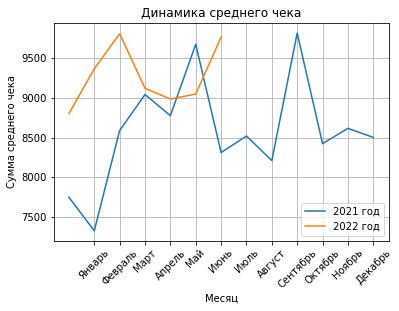

In [24]:
cheque['cheque'][:13].plot()
cheque['cheque'][13:].plot()
plt.grid(True)
plt.title('Динамика среднего чека')
plt.xlabel('Месяц')
plt.ylabel('Сумма среднего чека')
plt.legend(['2021 год','2022 год'])
plt.xticks(ticks= [i for i in range(1, 13)],
           labels = ['Январь','Февраль','Март','Апрель','Май','Июнь',
                     'Июль','Август','Сентябрь','Октябрь','Ноябрь','Декабрь'])
plt.xticks(rotation=45)
plt.show();

#### Средний чек в сравнении аналогичных периодов 2021 года и 2022 года:
- средний чек в 2022 году вырос на 7.95% по сравнению с 2021 годом
- в начале года средний чек рос до мая в 2021 году и до февраля в 2021 году
- в 2021 году прибыль медленно росла до окрября, средний чек рос до мая, упала летом и потом восстанавливилась
- в 2022 году прибыль до апреля росла, а потом падала - средний чек же упал уже в марте: делаем вывод о наплыве пациентов и небольшим средним чеком с марта по май. Возможно имела место акция с низкой стоимостью услуги, которая принесла прибыль благодаря большому количеству пациентов

#### Прибыль с разбивкой по категориям

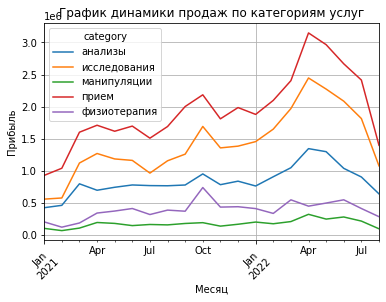

In [25]:
# составим сводную таблицу с доходом по категориям
category = df.pivot_table(index = 'mon_year',
                          columns = 'category',
                          values = 'service_amount',
                          aggfunc = 'sum')
# построим график прибыли
category.plot()
plt.grid(True)
plt.title('График динамики продаж по категориям услуг')
plt.xlabel('Месяц')
plt.ylabel('Прибыль')
plt.xticks(rotation=45)
plt.show();

#### Услуги категории "прием","исследования","физеотерапия" испытали небольшой скачек прибыли в октябре 2021 года, услуги категории "манипуляции" и "анализы" не испытали изменений.
#### В апреле 2022 года резко (на 30%) выросли  суммы продаж по категориям "прием" и "исследования", например, для ситуации когда пациент приходит к врачу и направляется на исследование, например, ЭКГ. Возможно,данный рост связан с политической обстановкой в мире

#### Разобьем услуги на категории по цене

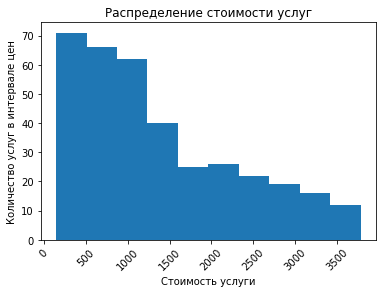

In [26]:
# попробуем разбить услуги на категории по цене
plt.hist(df['service_price'].unique())
plt.title('Распределение стоимости услуг')
plt.xlabel('Стоимость услуги')
plt.ylabel('Количество услуг в интервале цен')
plt.xticks(rotation=45)
plt.show();

In [27]:
# разобьем услуги на категории по цене
def sort(price):
    if price<500:
        return '<500'
    elif price<1300:
        return '<1300'
    elif price<1600:
        return '<1600'
    else:
        return '>1600'
df['sort_price'] = df['service_price'].apply(sort)
print('Проверим разбивку по количеству раз покупок на категории цен на услуги')
df['sort_price'].value_counts()/df.shape[0]

Проверим разбивку по количеству раз покупок на категории цен на услуги


<1600   0.32
<1300   0.31
<500    0.23
>1600   0.14
Name: sort_price, dtype: float64

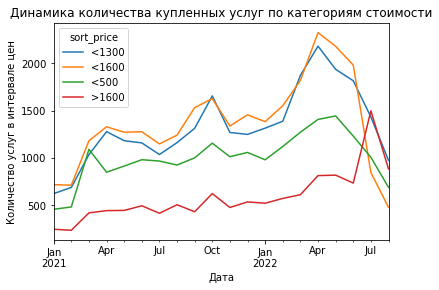

In [28]:
df.pivot_table(index = 'mon_year',
               columns = df['sort_price'],
               values = 'service_number',
               aggfunc = 'sum').plot()
plt.title('Динамика количества купленных услуг по категориям стоимости')
plt.xlabel('Дата')
plt.ylabel('Количество услуг в интервале цен')

plt.show();

#### Самые дешевые услуги оплачивают в 2 раза чаще, чем самые дорогие 
#### В марте 2021 года, вероятно, проводилась маркетинговая акция на только дешевые услуги, а в июле 2022 года -только на дорогие.  
#### Есть прирост количества покупок услуг в октябре 2021года и апреле 2022 года 


#### Рассмотрим количество уникальных пациентов за месяц и прирост

In [29]:
# рассмотрим количество уникальных пациентов за месяц и прирост %
insured = df.groupby(by='mon_year')['insured'].nunique()
# количество новых пользователей в каждый месяц
insured_new = df.groupby(by = 'insured')['mon_year'].agg('first').value_counts()
inc_con = pd.concat([insured,insured_new], axis=1).T
inc_con.index = ['Пациенты','Нов_пац-ты']
inc_con

,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08
Пациенты,285,308,443,465,466,433,447,487,558,586,536,558,553,586,659,786,798,736,636,357
Нов_пац-ты,285,218,264,216,209,179,165,189,196,206,179,197,207,230,223,364,331,247,224,137


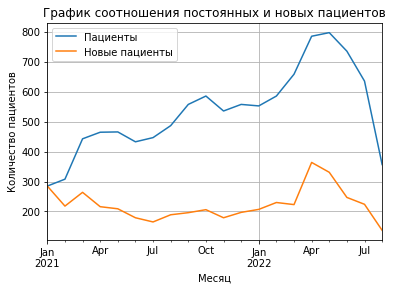

In [30]:
pd.concat([insured,insured_new], axis=1).plot()
plt.grid(True)
plt.title('График соотношения постоянных и новых пациентов')
plt.xlabel('Месяц')
plt.ylabel('Количество пациентов')
plt.legend(['Пациенты', 'Новые пациенты'])
plt.show();

#### C начала года 2021 года наблюдаем ежемесячный рост обслуживаемых пациентов и небольшим спадом в летние месяцы.
#### Рост количества пациентов в 2 раза к октябрю не за счет новых пациентов, вероятно, вызвал рост цен в октябре и ноябре. Например, специалистов или помещений стало не хватать. Пришлось расширить пропускную способность клиники. Рост цен в ноябре на 5%  вызвал спад пациентов на 10% пациентов в декабре 2021 года. 
#### Посещения восстановились к марту 2022 года. Далее наметился резкий рост вплодь до апреля-мая 2022 года и такое же резкое снижение - в 2 раза к августу. Новый рост цен случился в июле 2022 года и вызвал спад активности пациентов на 15%, однако если сравнить июль в 2021 и в 2022 году  - количество пациентов выросло в 1,5 раза. 
#### Пик апреля 2022 года характеризуется более резким всплеском активности новых пользователей, это не сезонный фактор, скорее маркетинговая кампания или реакция людей на события в мире.
----
#### Обобщим данные на графике, прирост метрик выражен в % от значений января 2021 год - сравнение будет корректным

In [31]:
# пронормируем на первый месяц периода и выразим в процентах
insured = 100*insured/insured['2021-01']-100
insured_new = 100*insured_new/insured_new['2021-01']-100
# присоединяем
data = pd.concat([data,insured], axis=1)
data = pd.concat([data,insured_new], axis=1)

data = data.rename(columns = {'insured':'Пациенты_%',
                              'mon_year':'Пациенты_New_%'})

data
print('Корреляция метрик с доходом')
data.corr()['Доход']

,Прирост_цены%,Доход,Прирост_дохода%,Пациенты_%,Пациенты_New_%
2021-01,0.00,2208448,0.00,0.00,0.00
2021-02,0.00,2257020,2.20,8.07,-23.51
2021-03,0.00,3804828,72.29,55.44,-7.37
2021-04,0.00,4204131,90.37,63.16,-24.21
2021-05,0.00,4089090,85.16,63.51,-26.67
2021-06,0.00,4188210,89.64,51.93,-37.19
2021-07,0.00,3715248,68.23,56.84,-42.11
2021-08,0.00,4148781,87.86,70.88,-33.68
2021-09,0.00,4581379,107.45,95.79,-31.23
2021-10,2.30,5750650,160.39,105.61,-27.72


Корреляция метрик с доходом


Прирост_цены%     0.59
Доход             1.00
Прирост_дохода%   1.00
Пациенты_%        0.98
Пациенты_New_%    0.52
Name: Доход, dtype: float64

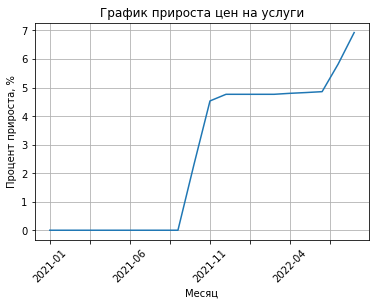

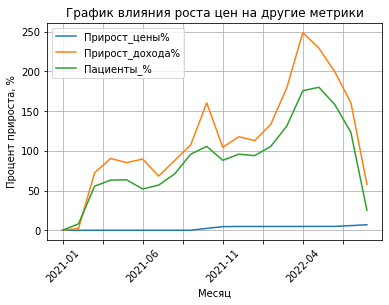

In [32]:
# строим графики
data['Прирост_цены%'].plot()
plt.grid(True)
plt.title('График прироста цен на услуги')
plt.xlabel('Месяц')
plt.ylabel('Процент прироста, %')
plt.xticks(rotation=45)
plt.show();

data.drop(['Доход','Пациенты_New_%'],axis =1).plot()
plt.grid(True)
plt.title('График влияния роста цен на другие метрики')
plt.xlabel('Месяц')
plt.ylabel('Процент прироста, %')
plt.xticks(rotation=45)
plt.show();

#### Рост дохода произошел за счет роста активности пациентов и в меньшей степени за счет роста цен. Вероятно пациенты не начали тратить больше, а стали чаще обращаться.
#### Можно предположить, что проводились акции, стимулирующие постоянных пациентов, а не привлекающие новых.


#### Услуги и цены рассмотрели, теперь рассмотрим портрет типичного пользователя

####  Профили пользователей 

In [33]:
# профили пользователей 
users = df.pivot_table(index = 'insured',
                       values = ['service_date',
                                 'service_number',
                                 'sex_id',
                                 'age_for_service_date',
                                 'service_amount'], 
                       aggfunc = {'service_date':'nunique',
                                  'service_number':'sum',
                                  'sex_id':'first',
                                  'age_for_service_date':'min',
                                  'service_amount':'sum'})

users = users.rename(columns = {'age_for_service_date':'Возраст',
                                'service_amount':'Сумма',
                                'service_date':'Визиты',
                                'service_number':'К-во_услуг',
                                'sex_id':'Пол'})
users['Чек'] = users['Сумма']/users['Визиты']
users

,Возраст,Сумма,Визиты,К-во_услуг,Пол,Чек
insured,,,,,,
125073,65,33080,15,27,2.00,"2,205.33"
125094,43,27519,7,20,2.00,"3,931.29"
125404,26,1470,1,1,1.00,"1,470.00"
139315,25,3300,1,3,1.00,"3,300.00"
139539,42,75239,19,56,2.00,"3,959.95"
...,...,...,...,...,...,...
1306765,32,15412,2,12,2.00,"7,706.00"
1306768,22,34237,5,36,2.00,"6,847.40"
1306775,37,40501,8,31,2.00,"5,062.62"


In [34]:
# Корреляции дохода клиники от половозрастных признаков пациента
print('Таблица корреляции признаков профиля пациента')
users.corr().sort_values(['Чек'])

Таблица корреляции признаков профиля пациента


,Возраст,Сумма,Визиты,К-во_услуг,Пол,Чек
Визиты,0.06,0.93,1.00,0.92,0.06,0.02
Пол,0.03,0.07,0.06,0.08,1.00,0.05
Возраст,1.00,0.12,0.06,0.12,0.03,0.14
Сумма,0.12,1.00,0.93,0.98,0.07,0.23
К-во_услуг,0.12,0.98,0.92,1.00,0.08,0.23
Чек,0.14,0.23,0.02,0.23,0.05,1.00


#### Количество принесенной клинике дохода очень слабо коррелирует с половозрастными признаками, сумма прибыли зависит от количества визитов в клинику.

#### Разобьем пациентов на возрастные группы: дошкольники, школьники, до 29 лет, 3030-40-40,41-50, 51-65, >65

In [35]:
def sort(age):
    if age < 18:
        return '<18'
    elif age < 30:
        return '18-29'
    elif age <= 40:
        return '30-40'
    elif age < 50:
        return '41-50'
    elif age < 65:
        return '50-64'
    else:
        return '65+'
df['sort_age'] = df['age_for_service_date'].apply(sort)
print('Проверим разбивку по возрасту')
df.groupby(by='sort_age')['insured'].nunique()
df.groupby(by='sex_id')['insured'].nunique()

Проверим разбивку по возрасту


sort_age
18-29    1171
30-40    1871
41-50     651
50-64     286
65+        31
<18       543
Name: insured, dtype: int64

sex_id
1.00    1926
2.00    2540
Name: insured, dtype: int64

#### Основной контингент 18-40 лет, взрослые трудоспособные люди чаще женщины
#### Рассмотрим график пациентов по половозрастным признакам 

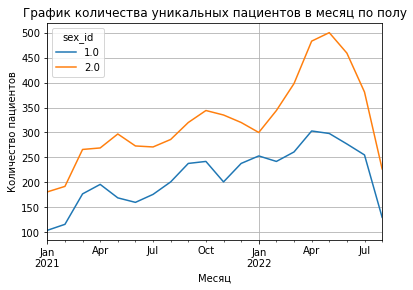

In [36]:
# построим диаграмму размаха пациентов по половозрастным признакам 
# в срезе скачков продаж в ноябрь-декабрь 2021 года и апрель-май 2022 годов

df.pivot_table(index = 'mon_year',
               columns = 'sex_id',
               values = 'insured',
               aggfunc = 'nunique').plot()
plt.grid(True)
plt.title('График количества уникальных пациентов в месяц по полу')
plt.xlabel('Месяц')
plt.ylabel('Количество пациентов')
plt.show();

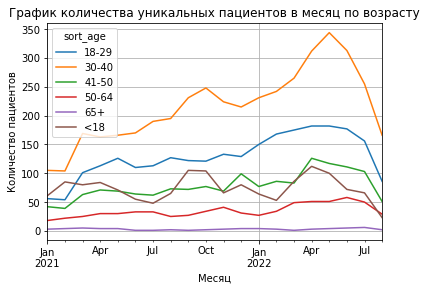

In [37]:
df.pivot_table(index = 'mon_year',
               columns = 'sort_age',
               values = 'insured',
               aggfunc = 'nunique').plot()
plt.grid(True)
plt.title('График количества уникальных пациентов в месяц по возрасту')
plt.xlabel('Месяц')
plt.ylabel('Количество пациентов')
plt.show();

#### Чаще других пользуются услугами клиники женщины и люди в возрастной категории 18-40 лет.
#### Кривые активности пациентов повторяют друг друга во всплесках активности до февраля 2022 года
#### Наплыв пациентов до 18 лет случился традиционно в сентябре 2021г а потом в апреле. 
#### Всплеск активности апреле - мая 2022 года обеспечен активностью лиц, в возрасте 30-40 лет, преимущественно женщин


#### По итогам исследования вывод по гипотезам:
    
- Гипотеза 1: Скачки прибыли вызваны пациентами определенных половозрастных групп. Гипотеза подтвердилась - скачки вызваны поведением групп пациентов женского пола и пациентов возраста 30-40лет.
- Гипотеза 2: Средняя стоимость обслуживания пациентов изменилась из-за изменения стоимости оказываемых услуг (раньше были дорогие услуги, теперь дешевые или наоборот) Гипотеза 2 подтвердилась - средняя стоимость лечения(средний чек) снизилась после увеличения стоимости услуг.

#### [-> Содержание](#sod)

### Шаг 4. Выводы <a class="anchor" id="sh4"></a> 

#### В клинике 772 уникальных услуг
#### На 10 услуг стоимость менялась 4-5 раз за период исследованя, на 233 услуги стоимость не менялась вообще, для остальных менялась 2-3 раза


#### Медиальный рост стоимости услуг происходил  в 2 основных этапа - октябрь-ноябрь 2021 года и июль-август 2022 года.

#### На 11 услуг стоимость снижалась - вероятно были маркетинговые акции

#### Клиника за период исследования увеличила свои доходы более чем в 2 раза, но с мая 2022 года доход начал падать. Активность пациентов в летний период падает и в 2021 году. Достатоно высокий коэфициэнт корреляции между приростом стоимости и приростом прибыли 0.59 не оправдывается на графиках: прирост стоимости услуг в октябре-ноябре 2021 и  в июне 2022 года вызвал снижение дохода. 

#### Средний чек в сравнении аналогичных периодов 2021 года и 2022 года:
- средний чек в 2022 году вырос на 7.95% по сравнению с 2021 годом
- в начале года средний чек рос до мая в 2021 году и до февраля в 2021 году
- в 2021 году прибыль медленно росла до окрября, средний чек рос до мая, упала летом и потом восстанавливилась
- в 2022 году прибыль до апреля росла, а потом падала - средний чек же упал уже в марте: делаем вывод о наплыве пациентов и небольшим средним чеком с марта по май. Возможно имела место акция с низкой стоимостью услуги, которая принесла прибыль благодаря большому количеству пациентов

#### Услуги типа "прием","исследования","физеотерапия" испытали небольшой скачек прибыли в октябре 2021 года, услуги типа "манипуляции" и "анализы" не испытали изменений 
#### В апреле 2022 года резко (на 30%) выросли  суммы продаж по категориям "прием" и "исследования".

#### Самые дешевые услуги оплачивают в 2 раза чаще, чем самые дорогие 
#### В марте 2021 года, вероятно, проводилась маркетинговая акция на только дешевые услуги, а в июле 2022 года -только на дорогие.  
#### Есть прирост количества покупок услуг в октябре 2021 года и апреле 2022 года 

#### C начала года 2021 года наблюдаем ежемесячный рост обслуживаемых пациентов и небольшим спадом в летние месяцы.
#### Рост количества пациентов в 2 раза к октябрю не за счет новых пациентов, вероятно, и вызвал рост цен в октябре и ноябре. Например, специалистов или помещений стало не хватать. Пришлось расширить пропускную способность клиники. Рост цен в ноябре на 5%  вызвал спад пациентов на 10% пациентов в декабре 2021 года. 
#### Посещения восстановились к марту 2022 года. Далее наметился резкий рост до апреля-мая 2022 года и такое же резкое снижение - в 2 раза к августу. Новый рост цен случился в июле 2022 года и вызвал спад активности пациентов на 15%, однако если сравнить июль в 2021 и в 2022 году  - количество пациентов выросло в 1,5 раза. 
#### Пик апреля 2022 года характеризуется более резким всплеском активности новых пользователей, это не сезонный фактор, скорее маркетинговая кампания или реакция людей на события в мире.

#### Проводились акции, стимулирующие постоянных пациентов, а не привлекающие новых.

#### Количество принесенной клинике дохода очень слабо коррелирует с половозрастными признаками, сумма прибыли зависит от количества визитов в клинику. Основной контингент 18-40 лет, взрослые трудоспособные люди чаще женщины

#### Чаще других пользуются услугами клиники женщины и люди в возрастной категории 18-40 лет.
#### Кривые активности пациентов повторяют друг друга во всплесках активности до февраля 2022 года
#### Наплыв пациентов до 18 лет случился традиционно в сентябре 2021г а потом в апреле.
#### Всплеск активности апреле - мая 2022 года обеспечен активностью лиц, в возрасте 30-40 лет, преимущественно женщин
#### По итогам исследования вывод по гипотезам:
- Гипотеза 1: Скачки прибыли вызваны пациентами определенных половозрастных групп. Гипотеза подтвердилась - скачки вызваны поведением групп пациентов женского пола и пациентов возраста 30-40лет.
- Гипотеза 2: Средняя стоимость обслуживания пациентов изменилась из-за изменения стоимости оказываемых услуг (раньше были дорогие услуги, теперь дешевые или наоборот) Гипотеза 2 подтвердилась - средняя стоимость лечения(средний чек) снизилась после увеличения стоимости услуг.



Еще планирую добавить в исследование: услуги-пары, услуги по которым были акции